### Computing the price in dollars of a trade, given the yield, and vice versa: get_price and get_ytw

Version dated July 19, 2021, most recently edited by Charles Elkan.

This notebook provides code to compute dollar prices, and compares the results to the prices reported by MSRB.
After the code for calculations, there is an analysis of discrepancies. 
When performed for multiple specific days, this analysis uncovers anomalies in MSRB or ICE data
that are summarized in https://docs.google.com/document/d/1ID3sdUC_Vvei-Cb-rUsrz0m_XFlAmcmlvhn57SNjwfo/edit.

There is only one cusip for which the evidence suggests that the code below is incorrect, namely 34061YAH3.
Our calculated price is too small by about 0.3, compared to the MSRB price,
i.e., about 30 cents out of $100. Our calculation becomes correct if the “dated date” is changed to be two weeks later than the date given by both ICE and MSRB. We don’t know for sure what value for “dated date” is used in the MSRB calculation.

The notebook also provides code to compute yields given prices.
An investigation of agreement with MSRB leads to recommendations for future work.

In [1]:
import pandas as pd
from pandas import NaT
pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import os
import numpy as np
import locale
from google.cloud import bigquery
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import scipy.optimize as optimize

locale.setlocale( locale.LC_ALL, 'en_US' )
tqdm.pandas()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../eng-reactor-287421-112eb767e1b3.json"

The SQL query below uses the flat table that is the output of a team member's pipelines. 
No trades are excluded, but we only take the most recent information for each trade.
For dates in the past, this query avoids some erroneous information because MSRB has published corrected trade messages.
However, there exist incorrect messages that remain permanently in the data.

Some of the fields that we do _not_ use from the pipelines are _muni__security__type_, _assumed__settlement_date_, 
_coupon__type_, _next__coupon__payment_date_, and _previous__coupon__payment_date_.
We can calculate prices without these fields, using in particular _interest__payment__frequency_ and _first__coupon__date_ instead.

In [2]:
def get_trade_data(bqclient, first_date, last_date=""):
    if last_date == "":
        last_date = first_date
    query = f''' SELECT
                cusip,
                trade_date,
                time_of_trade,
                trade_type,
                par_traded,
                dollar_price,
                yield,
                coupon AS coupon_rate,
                interest_payment_frequency,
                dated_date,
                settlement_date, 
                first_coupon_date,
                is_callable,
                next_call_date,
                next_call_price,
                par_call_date,
                par_call_price,
                is_called,
                called_redemption_type AS redemption_type,
                refund_date,
                refund_price,
                maturity_date,
                FROM `eng-reactor-287421.primary_views.trade_history_with_reference_data`
                WHERE MSRB_valid_to_date > current_date
                AND trade_date BETWEEN '{first_date}' AND '{last_date}'
             '''
    dataframe = bqclient.query(query).result().to_dataframe()
    return dataframe 

The current version of the notebook uses trades from one week in the past.
The query should take between two and three minutes, for any number of days of data.

In [3]:
bqclient = bigquery.Client()
%time muni_df = get_trade_data(bqclient, '2021-07-16')
len(muni_df)
hidden = muni_df.copy()

CPU times: user 1.38 s, sys: 91.1 ms, total: 1.47 s
Wall time: 2min 56s


The following mappings make trade records more readable. Note that many of the mapping values occur rarely or even never in the data.
In particular, the coupon frequency is every six months for over 95% of trades.
The function _transform__trade__data_ keeps the number of records unchanged, operating in-place on its argument.
It should not be applied twice to the same dataframe,
because performing the coupon frequency mapping twice is incorrect.
Bonds with deferred interest include zero-coupon bonds.

In [4]:
COUPON_FREQUENCY_DICT = {0:None,
                         1:2,
                         2:12,
                         3:1,
                         4:52,
                         5:4,
                         6:0.5,
                         7:1/3,
                         8:1/4,
                         9:1/5,
                         10:1/7,
                         11:1/8,
                         12:26,
                         13:None,
                         14:360,
                         16:0,
                         23:None}

def transform_trade_data(df):
    df['interest_payment_frequency'] = df['interest_payment_frequency'].map(COUPON_FREQUENCY_DICT)
    df['coupon_rate'] = df['coupon_rate'].astype(float)
    df['deferred'] = (df.interest_payment_frequency == 0) | df.coupon_rate == 0
    
    df['next_call_price'] = df['next_call_price'].astype(float)
    fields = ['trade_date', 'dated_date', 'settlement_date', 'first_coupon_date', 
              'next_call_date', 'par_call_date', 'refund_date', 'maturity_date']
    for f in fields: df[f] = pd.to_datetime(df[f])
    return df

vanilla = transform_trade_data(muni_df.copy())
len(vanilla), len(vanilla[vanilla.interest_payment_frequency == 2])

(24524, 23942)

We define anomalous trades to be those with negative yield, size under $5000, or missing settlement date, or missing first payment date despite a non-zero coupon.
These constitute about 1% of trades. 
For them, a discrepancy in price calculation is common, but likely not caused by an error in our code.

<!-- Note that in Python, a condition such as _A >= 0_ is _False_ if the variable _A_ is null,
so the condition below on payment frequency includes the case where the frequency is unknown.
-->

In [5]:
vanilla['anomaly'] = (vanilla.par_traded < 5000) | (vanilla['yield'] < 0) 
print(len(vanilla[vanilla.anomaly]))

vanilla['anomaly'] = vanilla['anomaly'] | pd.isnull(vanilla.settlement_date) | pd.isnull(vanilla.first_coupon_date) & vanilla.deferred
print(len(vanilla[vanilla.anomaly]))

332
332


We handle only the 360/30 convention for date calculations. For details, see MSRB Rule 33-G.

In [6]:
def diff_in_days(end_date, start_date, convention="360/30"):
    if convention != "360/30": 
        print("unknown convention", convention)
    Y2 = end_date.year
    Y1 = start_date.year
    M2 = end_date.month
    M1 = start_date.month
    D2 = end_date.day 
    D1 = min(start_date.day, 30)
    if D1 == 30: 
        D2 = min(D2,30)
    return (Y2 - Y1) * 360 + (M2 - M1) * 30 + (D2 - D1)

def get_next_coupon_date(first_coupon_date,settlement_date,time_delta):
    date = first_coupon_date
    while date < settlement_date:
        date = date + time_delta
    return date

The following function calculates the price of a trade, where _ytw_ is a specific yield and _end__date_ is a fixed repayment date.
All dates must be valid relative to the settlement date, as opposed to the trade date.
Note that "yield" is a reserved word in Python and should not be used as the name of a variable.

Formulas are from https://www.msrb.org/pdf.aspx?url=https%3A%2F%2Fwww.msrb.org%2FRules-and-Interpretations%2FMSRB-Rules%2FGeneral%2FRule-G-33.aspx.
For all bonds, _base_ is the present value of future cashflows to the buyer. 
The clean price is this price minus the accumulated amount of simple interest that the buyer must pay to the seller, which is called _accrued_.
Zero-coupon bonds are handled first. For these, the yield is assumed to be compounded semi-annually, i.e., once every six months.
For bonds with non-zero coupon, the first and last interest payment periods may have a non-standard length,
so they must be handled separately.

In [7]:
def get_price(cusip, dollar_price, my_prev_coupon_date, first_coupon_date, my_next_coupon_date, end_date,
              settlement_date, dated_date, frequency, ytw, coupon, RV, time_delta, printme):
#     if cusip == "34061YAH3": my_prev_coupon_date += relativedelta(weeks = 2)
        
    if pd.isnull(end_date): return np.inf
    B = 360
    Y = ytw/100
    
    if frequency == 0:
        A = diff_in_days(settlement_date,dated_date)
        accrued = coupon*A/B        
        duration = diff_in_days(end_date,settlement_date)
        periods = duration/(B/2)
        denom = pow(1 + Y/2, periods)
        DIR = diff_in_days(end_date,dated_date)
        base = (RV + coupon*DIR/B) / denom
        P = base - accrued
    else:
        if my_next_coupon_date > end_date: N = 0
        else:
            N = 1
            final_coupon_date = my_next_coupon_date
            while final_coupon_date + time_delta <= end_date:
                N += 1
                final_coupon_date += time_delta            

        A = diff_in_days(settlement_date,my_prev_coupon_date)
        if A < 0:
            print(cusip, A, settlement_date,my_prev_coupon_date)
            
        accrued = coupon*A/B
        E = B/frequency           # = number of days in interest payment period 
        assert E == round(E)
        
        F = diff_in_days(my_next_coupon_date,settlement_date)
        if my_next_coupon_date == first_coupon_date:
            G = diff_in_days(first_coupon_date,dated_date)
        else:
            G = E

        if end_date <= my_next_coupon_date:
            D = diff_in_days(end_date,settlement_date) 
            H = diff_in_days(end_date,my_prev_coupon_date) 
            base = (RV + coupon*H/B) / (1 + (Y/frequency)*D/E)
        else:
            D = diff_in_days(end_date,final_coupon_date) 
            S1 = (RV + coupon*D/B) / pow(1 + Y/frequency, F/E + N - 1 + D/E)

            S2 = coupon*G/B / pow(1 + Y/frequency, F/E)
            for K in range(2,N+1):
                S2 += coupon*E/B / pow(1 + Y/frequency, F/E + K - 1)
            base = S1 + S2
        P = base - accrued
                
    if printme: 
        delta = dollar_price - P; print("\n", locals())
    
    return round(P,3)

Next is the main function for computing prices.
For bonds that have not been called, the price is the lowest of three present values: to the next call date (which may be above par),
to the next par call date, and to maturity.

<!-- We detect additional rare anomalous trades: with null coupon frequency, or with previous coupon date before settlement date. -->

We use _first__coupon__date_ from the reference data, but we compute our own values for other coupon dates.
For bonds that have been called, the date of refunding is often missing.
For most types of redemption, this date is the next call date.
For redemption types 1 and 5, the refunding date is the maturity date.
However, MSRB sometimes uses the next call date for type 5,
in which case our calculation gives a different result.

Note that the condition "x >= y" evaluates to _False_ if either _x_ or _y_ is _NaT_.
Therefore, "not trade.first_coupon_date >= trade.dated_date" is _True_ when _first__coupon__date_ is _NaT_.

In [8]:
def compute_price(trade):
    anomaly = trade.anomaly
    printme = trade.alert
    
    frequency = trade.interest_payment_frequency
    if not frequency >= 0: # includes null frequency
        anomaly = True
        frequency = 2

    if frequency == 0:
        time_delta = 0
        my_next_coupon_date = trade.maturity_date
        my_prev_coupon_date = trade.dated_date
    else:
        time_delta = relativedelta(months = 12/frequency)
        if not trade.first_coupon_date >= trade.dated_date:
            printme = True
            anomaly = True
            print("bad first coupon date:", trade.cusip, trade.first_coupon_date)
            my_first_date = trade.dated_date
        else:
            my_first_date = trade.first_coupon_date
            
        my_next_coupon_date = get_next_coupon_date(my_first_date, trade.settlement_date, time_delta)
        if my_next_coupon_date == trade.first_coupon_date:
            my_prev_coupon_date = trade.dated_date
        else:
            my_prev_coupon_date = my_next_coupon_date - time_delta

    if trade.is_called:
        if pd.isnull(trade.refund_date):
            if trade.redemption_type in [1,5]:
                end_date = trade.maturity_date
            else:
                end_date = trade.next_call_date
        else:
            end_date = trade.refund_date
            
        if trade.refund_date < trade.settlement_date:
            anomaly = True
            printme = True
            print("anomalous refund date:", trade.cusip, "settlement:", trade.settlement_date, "refunding:", trade.refund_date)
            
        if not pd.isnull(trade.refund_price):
            par = trade.refund_price
        elif not pd.isnull(trade.next_call_price): 
            par = trade.next_call_price
        else: 
            par = 100
        final = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                         end_date,trade.settlement_date, trade.dated_date, frequency,
                         trade['yield'], trade.coupon_rate, par, time_delta, printme)
        calc = "refunding"
    else:
    
        next_price = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                            trade.next_call_date,trade.settlement_date,trade.dated_date, frequency,
                            trade['yield'],trade.coupon_rate,trade.next_call_price,time_delta, printme)

        to_par_price = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                            trade.par_call_date,trade.settlement_date,trade.dated_date, frequency,
                            trade['yield'],trade.coupon_rate,trade.par_call_price,time_delta, printme)

        maturity_price = get_price(trade.cusip,trade.dollar_price,my_prev_coupon_date,trade.first_coupon_date,my_next_coupon_date,
                            trade.maturity_date,trade.settlement_date,trade.dated_date, frequency,
                            trade['yield'],trade.coupon_rate,100,time_delta, printme)
        
        final = next_price; calc = "next call"
        if to_par_price < final:
            final = to_par_price; calc = "par call"
        if maturity_price < final:
            final = maturity_price; calc = "maturity"
        
    if printme: print(locals(), "\n==============")
    return final, calc, anomaly

We set _alert_ to be _True_ for trades where we want to see comprehensive information for debugging.

In [9]:
print(len(vanilla[vanilla.anomaly]))
vanilla['alert'] = False # vanilla.cusip == "89386FAD5" # vanilla.redemption_type == 5 # vanilla.cusip == "803093AM5" # 
len(vanilla[vanilla['alert']])

332


0

For each trade, we compute the price, the date of repayment assumed for this price, and we update whether the trade is anomalous.
An M1 MacBook Air performs about 2200 price calculations per second.

In [10]:
vanilla['my_price'], vanilla['my_date'], vanilla['anomaly'] = zip(*vanilla.progress_apply(lambda x: compute_price(x),axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 24524/24524 [00:10<00:00, 2372.55it/s]


<br>

### Analyzing the correctness of price calculations

For this analysis, we first measure the fraction of trades with a discrepancy of more than one cent in price.
On most days this fraction is less than 2%.

In [11]:
vanilla['price_delta'] = abs(vanilla.my_price - vanilla.dollar_price)
tol = 0.01
len(vanilla[vanilla.price_delta > tol])/len(vanilla), len(vanilla), max(vanilla.price_delta)

(0.01745229163268635, 24524, 2374.362)

Next we count discrepancies separately for hard and easy cases.
The basic definition of "hard" is the same as the definition of an anomaly.
The majority of anomalous trades have a large discrepancy,
but only around 1% of non-anomalous trades.

In [12]:
pred = vanilla['anomaly']
hard = vanilla[pred]
print( len(hard[hard.price_delta > tol]), len(hard) )
easy = vanilla[~pred]
len(easy[easy.price_delta > tol]), len(easy)

229 332


(199, 24192)

The following scatter plot shows that for non-anomalous trades, most price calculations have no discrepancy,
and the discrepancies that do exist are mostly small.

<AxesSubplot:xlabel='dollar_price', ylabel='my_price'>

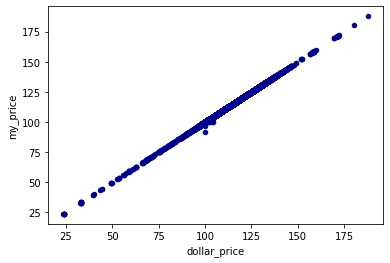

In [13]:
easy.plot.scatter(x='dollar_price', y='my_price', c='DarkBlue')

In contrast, extreme discrepancies exist for some anomalous trades.

<AxesSubplot:xlabel='dollar_price', ylabel='my_price'>

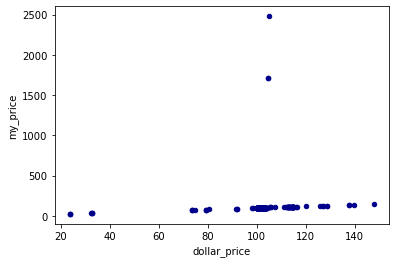

In [14]:
hard.plot.scatter(x='dollar_price', y='my_price', c='DarkBlue')

Next we display details for the non-anomalous trades with largest disagreement.
If there are multiple trades for the same series,
only the trade with largest discrepancy is retained,
because the trades and/or the discrepancies are likely to be related.

Selected trades are discussed in https://docs.google.com/document/d/1ID3sdUC_Vvei-Cb-rUsrz0m_XFlAmcmlvhn57SNjwfo/edit.
Often, the cause of disagreement is a different call or redemption date.
This includes cases where MSRB prices to call even though the yield to worst is to maturity, or vice versa;
in these cases, the discrepancy is often small because the price is close to 100.
It also includes cases where _redemption__type_ equals 5 and MSRB prices to the next call date instead of to maturity;
in these cases, the disagreement is often large.

In [15]:
view = easy.copy()
view['series'] = view.cusip.str[:6]
view = view.sort_values(by=['series','price_delta'],ascending=True)
view = view.loc[view.shift(-1).series != view.series]
view = view.sort_values(by=['price_delta'],ascending=False)
view[0:10]

,cusip,trade_date,time_of_trade,trade_type,par_traded,dollar_price,yield,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,deferred,anomaly,alert,my_price,my_date,price_delta,series
22722,455114HN1,2021-07-16,14:04:19,D,10000,99.944,4.023,3.20,2.0,2012-12-20,2021-07-20,2013-04-01,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2035-04-01,False,False,False,91.394,maturity,8.550,455114
22832,235308RA3,2021-07-16,08:47:17,S,5000,104.100,6.003,6.45,2.0,2010-11-15,2021-07-20,2011-08-15,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2035-02-15,False,False,False,100.026,next call,4.074,235308
22795,65825PEC0,2021-07-16,15:05:22,P,35000,99.980,4.400,4.00,2.0,2011-11-29,2021-07-20,2012-05-01,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2032-05-01,False,False,False,96.590,maturity,3.390,65825P
22823,914302BC7,2021-07-16,12:51:38,D,85000,102.235,1.033,5.00,2.0,2011-12-15,2021-07-20,2012-08-15,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2022-02-15,False,False,False,100.285,next call,1.950,914302
22554,44420PDQ4,2021-07-16,15:50:42,S,15000,101.625,4.888,5.00,2.0,2011-10-26,2021-07-16,2012-02-15,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2047-02-15,False,False,False,100.005,next call,1.620,44420P
3524,478164FF8,2021-07-16,14:05:04,P,15000,99.740,5.049,5.00,2.0,2011-08-01,2021-07-20,2012-03-01,False,2021-09-01,100.0,2021-09-01,100.0,True,17.0,2021-09-01,100.000000,2027-09-01,False,False,False,99.983,refunding,0.243,478164
21389,64966QWJ5,2021-07-16,16:17:17,P,30000,134.256,1.240,5.00,2.0,2008-04-23,2021-07-20,2021-10-01,True,2031-04-01,100.0,2031-04-01,100.0,False,NaN,NaT,NaN,2034-04-01,False,False,False,134.095,next call,0.161,64966Q
24518,668844UT8,2021-07-16,11:37:10,S,630000,131.969,0.823,5.00,2.0,2021-07-29,2021-07-29,2022-07-15,True,2029-07-15,100.0,2029-07-15,100.0,False,NaN,NaT,NaN,2030-07-15,False,False,False,132.115,next call,0.146,668844
3813,485429UX0,2021-07-16,14:04:00,D,50000,100.085,0.856,5.25,2.0,2013-08-15,2021-07-20,2013-12-01,True,2021-08-06,100.0,2021-08-06,100.0,False,NaN,NaT,NaN,2038-06-01,False,False,False,100.195,next call,0.110,485429
18599,358232M86,2021-07-16,10:01:51,P,15000,73.298,3.017,0.00,0.0,2011-10-13,2021-07-16,2026-08-01,False,NaT,NaN,NaT,NaN,True,17.0,2021-08-01,73.298851,2026-08-01,False,False,False,73.207,refunding,0.091,358232


<br>

### A digression: Are discrepancies equally likely to be positive and negative?

The following function evaluates the null hypothesis that the average discrepancy between the MSRB price and our price is zero.
The hypothesis is evaluated separately for discrepancies above and below a threshold, which by default is 0.01, i.e., one cent.

If there exist multiple trades for a cusip with the same settlement date,
for example multiple when-issued trades,
then it is likely that these are related.
However, the statistical test is valid only for independent observations, so only one of these trades is retained.

In [16]:
def mytstat(d):
    return len(d), d.mean(), d.mean() / ( d.std()/np.sqrt(len(d)-1) )

def tstat(diff, threshold = 0.01):
    diff = diff.sort_values(by=['settlement_date','cusip'])
    diff = diff.loc[diff.shift(-1).cusip != diff.cusip]
    d = diff.dollar_price - diff.my_price
    return mytstat(d[abs(d) <= threshold]), mytstat(d[abs(d) > threshold])

tstat(hard)

((45, 0.00017777777777925824, 0.384173266294044),
 (107, -15.112140186915891, -0.9986438954008244))

A t-statistic above or below 1.96 is significant at the 5% level. 
The results above show that the mean discrepancy for anomalous trades may be not significantly different from zero.

However, the next box shows that for non-anomalous trades,
when the discrepancy is less than one cent, 
then it is significantly more likely to be negative than positive.
In other words, the typical MSRB price is less than our computed price,
when the two prices essentially agree.
This average discrepancy is statistically significant, but in absolute value it is trivial,
about one hundredth of one cent.
We do not have an explanation for why the result is statistically significant.

In [17]:
tstat(easy)

((10442, -0.0001299559471366397, -7.460889835695709),
 (71, 0.1596619718309873, 1.9250580086129112))

<br>

### Computing the yield of a trade, given its dollar price

This section uses an optimization algorithm to find the yield that corresponds to a given price. 
To perform the optimization we use a bisection method, because it is more robust than Newton's method.
We search for the yield inside the interval -99% to 99%.
The auxiliary function _aux__price_ is needed because of limitations in Python on what can appear inside a lambda expression.

In [18]:
def aux_price(trade, Y):
    myt = trade.copy()
    myt['yield'] = Y
    c = compute_price(myt)
    return c[0]
    
def compute_yield(trade):
    ytw_func = lambda Y: aux_price(trade,Y) - trade.dollar_price
    ytw = optimize.brentq(ytw_func, -99, 99)
    return round(ytw, 4)

The optimization is rather slow, running at about 250 trades per second on an M1 Macbook Air. This can be made faster in future work.

In [19]:
vanilla['my_ytw'] = vanilla.progress_apply(lambda x: compute_yield(x), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24524/24524 [01:33<00:00, 263.18it/s]


Next, we investigate the accuracy of the _compute__yield_ calculations.
First, we see that about 95% of results agree with the yield reported by MSRB to within 1/1000 of one percentage point (one tenth of a basis point).

In [20]:
vanilla['y_delta'] = abs(vanilla['yield'] - vanilla.my_ytw)
tol = 0.001
len(vanilla[vanilla.y_delta > tol])/len(vanilla), len(vanilla), max(vanilla.y_delta)

(0.054314141249388354, 24524, 65.0303)

For the majority of trades where the disagreement is large, the date at which the bond will be redeemed is less than two months after the settlement date.
We call these the additional "hard" trades for calculating yield.
Note that the function _nearby_ assumes that the _my__date_ field has already been stored in its argument,
which happens above when _compute__price_ is applied to every trade.

In [21]:
def nearby(x):
    if x.my_date == "refunding":
        d = x.refund_date
    elif x.my_date == "next call":
        d = x.next_call_date
    elif x.my_date == "par call":
        d = x.par_call_date
    else:
        d = x.maturity_date
    return d <= x.settlement_date + relativedelta(months = 2)

pred = vanilla.apply(nearby, axis=1) | vanilla['anomaly']
hard = vanilla[pred]
print( len(hard[hard.y_delta > tol]), len(hard) )
easy = vanilla[~pred]
len(easy[easy.y_delta > tol]), len(easy)

741 879


(591, 23645)

The following two plots show that there are many large yield discrepancies for "hard" trades, but fewer for "easy" trades.

<AxesSubplot:xlabel='yield', ylabel='my_ytw'>

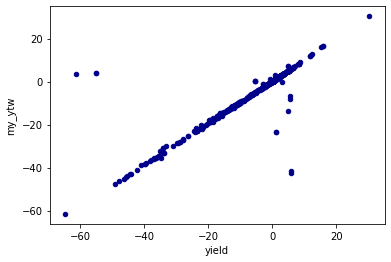

In [22]:
hard.plot.scatter(x='yield', y='my_ytw', c='DarkBlue')

<AxesSubplot:xlabel='yield', ylabel='my_ytw'>

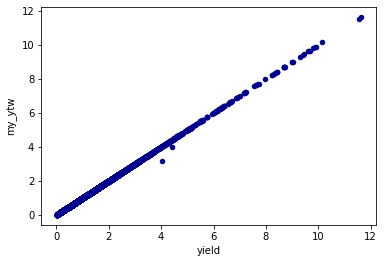

In [23]:
easy.plot.scatter(x='yield', y='my_ytw', c='DarkBlue')

We investigate the largest discrepancies among "easy" trades.
For July 16, 2021, two discrepancies stand out, for cusips 455114HN1 and 65825PEC0.
The trade at 2:04pm in cusip 455114HN1 is priced to the next call date by MSRB,
but should be priced to maturity since the price is less than 100.
The trade at 3:05pm in cusip 65825PEC0 is also priced to call by MSRB, but should be priced to maturity.

The third largest discrepancy in yield is for cusip 668844UT8.
We price this bond to its next call date, which is July 15, 2029.
However, MSRB prices this bond to July 1, 2029.
According to the bottom of the seventh page of https://emma.msrb.org/P11511669-P11170092-P11585785.pdf,
July 15, 2029 is the correct first call date.


In [24]:
view = easy.copy()
view['series'] = view.cusip.str[:6]
view = view.sort_values(by=['series','y_delta'],ascending=True)
view = view.loc[view.shift(-1).series != view.series]
view = view.sort_values(by=['y_delta'],ascending=False)
view[0:5]

,cusip,trade_date,time_of_trade,trade_type,par_traded,dollar_price,yield,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,deferred,anomaly,alert,my_price,my_date,price_delta,my_ytw,y_delta,series
22722,455114HN1,2021-07-16,14:04:19,D,10000,99.944,4.023,3.2,2.0,2012-12-20,2021-07-20,2013-04-01,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2035-04-01,False,False,False,91.394,maturity,8.550,3.2048,0.8182,455114
22795,65825PEC0,2021-07-16,15:05:22,P,35000,99.980,4.400,4.0,2.0,2011-11-29,2021-07-20,2012-05-01,True,2021-08-16,100.0,2021-08-16,100.0,False,NaN,NaT,NaN,2032-05-01,False,False,False,96.590,maturity,3.390,4.0017,0.3983,65825P
24518,668844UT8,2021-07-16,11:37:10,S,630000,131.969,0.823,5.0,2.0,2021-07-29,2021-07-29,2022-07-15,True,2029-07-15,100.0,2029-07-15,100.0,False,NaN,NaT,NaN,2030-07-15,False,False,False,132.115,next call,0.146,0.8392,0.0162,668844
19485,438670YD7,2021-07-16,12:29:29,P,20000,100.000,3.926,4.0,2.0,2011-08-04,2021-07-20,2012-08-01,False,NaT,NaN,NaT,NaN,True,5.0,NaT,NaN,2021-08-01,False,False,False,100.000,refunding,0.000,3.9113,0.0147,438670
21389,64966QWJ5,2021-07-16,16:17:17,P,30000,134.256,1.240,5.0,2.0,2008-04-23,2021-07-20,2021-10-01,True,2031-04-01,100.0,2031-04-01,100.0,False,NaN,NaT,NaN,2034-04-01,False,False,False,134.095,next call,0.161,1.2253,0.0147,64966Q


<br>

### Conclusions

For further work, we have two main needs:
1. A function get_price that converts predicted yields into predicted prices.
2. Clean datasets for training and evaluating our predictive models.
For the first need, the function _compute__price_ above is adequate, at least for the near future. 
We should decline to provide a prediction for trades with unknown first payment date despite a non-zero coupon.

For the second need, we should keep only historical trades whose MSRB yields are clearly correct.
These are trades where our computed price (based on the MSRB yield) equals the MSRB price within one cent,
and also our computed yield (based on the MSRB price) equals the MSRB yield within 1/1000 of a percentage point.
These are over 90% of all trades.


In [25]:
print( len(vanilla) )
print( len(vanilla[vanilla.y_delta < .001]) )
print( len(vanilla[(vanilla.price_delta < .01)]) )
len(vanilla[(vanilla.y_delta < .001) & (vanilla.price_delta < .01)])

24524
23192
24096


23148